In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
! jupyter nbextension enable --py widgetsnbextension
np.set_printoptions(suppress=True)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


<h1>Load in and Split <code>catboost_data.parquet</code>

In [2]:
# We only want to keep pitch_type_shift, so drop pitch_type
### This may be something we might want to include next time.
# catboost_df.drop(columns='pitch_type', inplace=True)
catboost_df = pd.read_parquet('catboost_data.parquet')
X = catboost_df.iloc[:, :-1]
y = catboost_df.iloc[:, -1]
print(f'X.shape, y.shape : {X.shape}, {y.shape}')

X.shape, y.shape : (3514339, 15), (3514339,)


In [3]:
# Split our data
X_train, X_val, y_train, y_val = train_test_split(
	X, y, test_size=0.25, random_state=28)

# Define the hyperparameters for the CatBoost algorithm
# params = {'learning_rate': 0.1, 
#           'depth': 6,
# 		  'l2_leaf_reg': 3,
#           'iterations': 25}
    # Best iteration 24, Best test 1.507
params = {'learning_rate': 0.05, 
          'depth': 7,
		  'l2_leaf_reg': 4,
          'iterations': 30}

# Get indicies where column data types are not floats.
categorical_features_indices = [i for i, dtype in enumerate(X.dtypes) if dtype not in (float, int)]

# Initialize the CatBoostClassifier object
# with the defined hyperparameters and fit it on the training set
model = CatBoostClassifier(**params)
# model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_val, y_val), save_snapshot=True, 
#           snapshot_file='catboost_snapshot/', snapshot_interval=6, verbose=True)

model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_val, y_val), verbose=True)

0:	learn: 2.8057517	test: 2.8058269	best: 2.8058269 (0)	total: 15s	remaining: 7m 16s
1:	learn: 2.7050934	test: 2.7051607	best: 2.7051607 (1)	total: 44.4s	remaining: 10m 21s
2:	learn: 2.6212331	test: 2.6213110	best: 2.6213110 (2)	total: 1m 30s	remaining: 13m 38s
3:	learn: 2.5517881	test: 2.5518956	best: 2.5518956 (3)	total: 2m 8s	remaining: 13m 53s
4:	learn: 2.4922941	test: 2.4924269	best: 2.4924269 (4)	total: 3m 5s	remaining: 15m 28s
5:	learn: 2.4406385	test: 2.4408065	best: 2.4408065 (5)	total: 4m 57s	remaining: 19m 50s
6:	learn: 2.3952246	test: 2.3954310	best: 2.3954310 (6)	total: 5m 35s	remaining: 18m 22s
7:	learn: 2.3556120	test: 2.3558367	best: 2.3558367 (7)	total: 6m 5s	remaining: 16m 46s
8:	learn: 2.3202875	test: 2.3205338	best: 2.3205338 (8)	total: 6m 39s	remaining: 15m 31s
9:	learn: 2.2873447	test: 2.2876027	best: 2.2876027 (9)	total: 7m 7s	remaining: 14m 14s
10:	learn: 2.2581374	test: 2.2584004	best: 2.2584004 (10)	total: 7m 40s	remaining: 13m 15s
11:	learn: 2.2309591	test: 2

In [6]:
prediction = model.predict(X_val)
print(model.score(X_val, y_val))

0.44031140982375067


In [7]:
for col, feat in zip(X_train.columns, model.feature_importances_):
    print(f"{col}: {feat}")

print(np.sum(model.feature_importances_))

full_name: 77.03917554691064
b_score: 0.15459278002851368
b_count: 3.6205354201558237
s_count: 2.7123093636336257
current_outs: 0.1825460060623661
pitch_num: 0.7936781024861055
on_1b: 0.12237178944782307
on_2b: 0.10132702998156719
on_3b: 0.0
batter_id: 0.06077198962219439
inning: 3.011443967865674
p_score: 0.008457041887777237
p_throws: 6.080323718828767
batter_stance: 6.112467243089138
top: 0.0
100.00000000000003


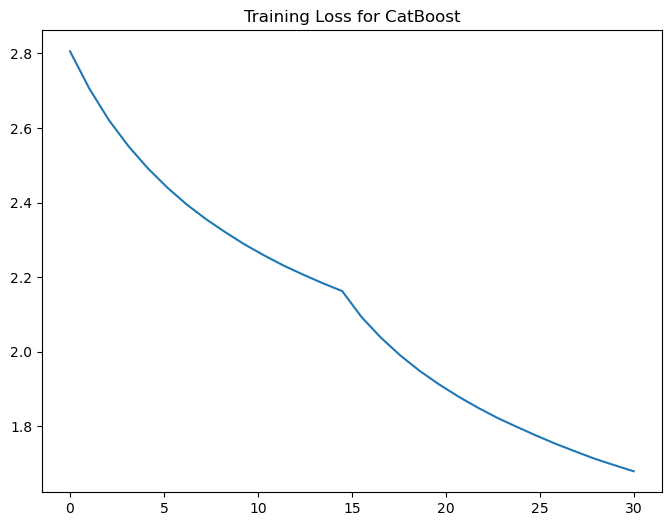

In [16]:
plt.figure(figsize=(8,6), dpi=100)
# Print out the information from catboost
train_results = pd.read_csv('catboost_info/learn_error.tsv', sep='\t', index_col='iter')['MultiClass'].to_numpy()
test_results = pd.read_csv('catboost_info/test_error.tsv', sep='\t', index_col='iter')['MultiClass'].to_numpy()
train_results
test_results
plt.plot(np.linspace(0, 30, len(train_results)), train_results)
plt.title('Training Loss for CatBoost')
plt.show()